In [1]:
%pip install pandas -q
%pip install matplotlib -q
%pip install kagglehub -q
%pip install tensorflow -q
%pip install scikit-learn -q
%pip install seaborn -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import tensorflow as tf
import seaborn as sns

from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, MaxPool2D, GlobalAveragePooling2D, Dropout, BatchNormalization, RandomContrast, RandomZoom, RandomTranslation, RandomRotation, SeparableConv2D, Rescaling 
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.applications.resnet50 import preprocess_input

from sklearn.metrics import confusion_matrix, classification_report

RANDOM_SEED = 42
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
    
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

2025-08-03 09:33:11.042412: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-03 09:33:11.433034: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754202791.576005    3116 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754202791.615437    3116 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754202791.932964    3116 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
# загрузим данные
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")


In [4]:
# преднастройка формаирование датасета
settings_loading_data = dict(
    labels='inferred',
    label_mode='binary',
    color_mode='grayscale',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='bicubic', # bicubic bilinear
    batch_size=BATCH_SIZE,
    seed=RANDOM_SEED
)

In [5]:
# сформируем датасеты
df_train = image_dataset_from_directory(
    path + '/chest_xray/train',
    shuffle=True,
    **settings_loading_data
)

df_valid = image_dataset_from_directory(
    path + '/chest_xray/val',
    shuffle=False,
    **settings_loading_data
)

df_test = image_dataset_from_directory(
    path + '/chest_xray/test',
    shuffle=False,
    **settings_loading_data
)

Found 5216 files belonging to 2 classes.


I0000 00:00:1754202795.011091    3116 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5529 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [6]:
# вывод 9 фотографий из датасета для примера
class_names = df_train.class_names
print("Классы:", class_names)

# for images, labels in df_train.take(1):
#     plt.figure(figsize=(10, 10))
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8").squeeze(), cmap='gray') 
#         plt.title(f"Class: {class_names[int(labels[i].numpy().item())]}")
#         plt.axis("off")
#     plt.show()

Классы: ['NORMAL', 'PNEUMONIA']


In [7]:
# т.к. 16 изображений валидационной выборки - это очень мало, то объединим test с val, а потом разобьем их
df_train_full = df_train.concatenate(df_valid)
val_size = int(len(df_train_full) * 0.2)

df_valid = df_train_full.take(val_size)
df_train = df_train_full.skip(val_size)

print(f"Новый размер train (батчей): {len(df_train)}")
print(f"Новый размер valid (батчей): {len(df_valid)}")

Новый размер train (батчей): 132
Новый размер valid (батчей): 32


In [8]:
# проверим баланс классов
# TODO - сделать попроще это ячейку
labels = []
for _, label_batch in df_train:
    labels.extend(label_batch.numpy())

normal_count = np.sum(np.array(labels) == 0)
pneumonia_count = np.sum(np.array(labels) == 1)

print(f"Класс NORMAL (0): {normal_count} изображений")
print(f"Класс PNEUMONIA (1): {pneumonia_count} изображений")

Класс NORMAL (0): 1069 изображений
Класс PNEUMONIA (1): 3139 изображений


2025-08-03 09:33:20.090481: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
# настроим аугментацию
# 1. будем поворачивать фотографии, на 10 градусов в разные стороны
# 2. смещаем фотографии по вертикали и горизонатли на 10 процентов
# 3. зумим фотографии на 20 процентов
data_augmentation_pipeline = tf.keras.Sequential([
    RandomRotation(factor=10/360.0, fill_mode="nearest", interpolation="bilinear"),
    RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode="nearest", interpolation="bilinear"),
    RandomZoom(height_factor=0.2, width_factor=0.2, fill_mode="nearest", interpolation="bilinear")
])

In [10]:
# Функция аугментации и нормализации
def augment_and_normalize_train(image, label):
    image_augmented = data_augmentation_pipeline(image, training=True)
    return tf.cast(image_augmented, tf.float32), label

df_train_processed = df_train.map(augment_and_normalize_train, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
df_valid_processed = df_valid.prefetch(tf.data.AUTOTUNE)
df_test_processed = df_test.prefetch(tf.data.AUTOTUNE)

In [11]:
# проверим баланс классов
# TODO - сделать попроще это ячейку
labels = []
for _, label_batch in df_train_processed:
    labels.extend(label_batch.numpy())

normal_count = np.sum(np.array(labels) == 0)
pneumonia_count = np.sum(np.array(labels) == 1)

print(f"Класс NORMAL (0): {normal_count} изображений")
print(f"Класс PNEUMONIA (1): {pneumonia_count} изображений")

Класс NORMAL (0): 1073 изображений
Класс PNEUMONIA (1): 3135 изображений


2025-08-03 09:33:24.073055: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
# рассчитаем class_weights
# сделаем это через кол-во элементов одного и второго класса
labels = np.concatenate([y for x, y in df_train_processed], axis=0)
normal_count = np.sum(labels == 0)
pneumonia_count = np.sum(labels == 1)
total_count = len(labels)

weight_for_0 = (1 / normal_count) * (total_count / 2)
weight_for_1 = (1 / pneumonia_count) * (total_count / 2)

class_weights = {0: weight_for_0, 1: weight_for_1}

In [ ]:
# создадим модель
model = Sequential()

model.add(Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

model.add(SeparableConv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

model.add(SeparableConv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.2))

model.add(SeparableConv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy', 
    optimizer=Adam(learning_rate=1e-4), 
    metrics=[
        'accuracy',       
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)
model.summary()

/home/koziy/projects/xray_env/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 112, 112, 64)   │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 56, 56, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 28, 28, 256)    │        34,176 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,02

 Total params: 25,872,993 (98.70 MB)

 Trainable params: 25,870,497 (98.69 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [14]:
# используем коллбэки
# 1. Настройка learning rate при обучении
# 2. Сохранение лучшей версии модели
# 3. Остановка обучения, если нет улучшений
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    df_train_processed,
    validation_data=df_valid_processed,
    class_weight=class_weights,
    epochs=20,
    callbacks=[reduce_lr, model_checkpoint, early_stopping]
)

Epoch 1/20


I0000 00:00:1754202813.068553    3328 service.cc:152] XLA service 0x792900002120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754202813.068582    3328 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-08-03 09:33:33.496331: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754202814.306571    3328 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/132 ━━━━━━━━━━━━━━━━━━━━ 26:49 12s/step - accuracy: 0.4688 - auc: 0.2917 - loss: 1.0582 - precision: 0.6842 - recall: 0.5417

I0000 00:00:1754202821.121624    3328 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7584 - auc: 0.8799 - loss: 0.4778 - precision: 0.9358 - recall: 0.7209

132/132 ━━━━━━━━━━━━━━━━━━━━ 30s 137ms/step - accuracy: 0.7588 - auc: 0.8803 - loss: 0.4771 - precision: 0.9361 - recall: 0.7213 - val_accuracy: 0.7305 - val_auc: 0.5581 - val_loss: 0.5945 - val_precision: 0.7305 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/20
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8604 - auc: 0.9589 - loss: 0.2968 - precision: 0.9761 - recall: 0.8331

132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.8605 - auc: 0.9589 - loss: 0.2967 - precision: 0.9761 - recall: 0.8332 - val_accuracy: 0.7256 - val_auc: 0.6469 - val_loss: 0.5924 - val_precision: 0.7256 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8987 - auc: 0.9669 - loss: 0.2516 - precision: 0.9794 - recall: 0.8809 - val_accuracy: 0.6816 - val_auc: 0.6572 - val_loss: 0.5952 - val_precision: 0.7638 - val_recall: 0.8150 - learning_rate: 1.0000e-04
Epoch 4/20
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9051 - auc: 0.9744 - loss: 0.2218 - precision: 0.9813 - recall: 0.8896
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.9051 - auc: 0.9744 - loss: 0.2219 - precision: 0.9812 - recall: 0.8897 - val_accuracy: 0.7295 - val_auc: 0.7663 - val_loss: 1.3527 - val_precision: 0.7314 - val_recall: 0.9919 - learning_rate: 1.00

132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9093 - auc: 0.9709 - loss: 0.2285 - precision: 0.9819 - recall: 0.8946 - val_accuracy: 0.8623 - val_auc: 0.9656 - val_loss: 0.2892 - val_precision: 0.8490 - val_recall: 0.9852 - learning_rate: 2.0000e-05
Epoch 6/20
 97/132 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9207 - auc: 0.9802 - loss: 0.1906 - precision: 0.9818 - recall: 0.9099

132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.9190 - auc: 0.9794 - loss: 0.1942 - precision: 0.9821 - recall: 0.9075 - val_accuracy: 0.9561 - val_auc: 0.9906 - val_loss: 0.1439 - val_precision: 0.9848 - val_recall: 0.9546 - learning_rate: 2.0000e-05
Epoch 7/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.9183 - auc: 0.9752 - loss: 0.2090 - precision: 0.9789 - recall: 0.9094 - val_accuracy: 0.9473 - val_auc: 0.9885 - val_loss: 0.2159 - val_precision: 0.9958 - val_recall: 0.9324 - learning_rate: 2.0000e-05
Epoch 8/20
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9237 - auc: 0.9778 - loss: 0.2001 - precision: 0.9789 - recall: 0.9166
Epoch 8: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.9237 - auc: 0.9778 - loss: 0.2001 - precision: 0.9789 - recall: 0.9166 - val_accuracy: 0.9463 - val_auc: 0.9890 - val_loss: 0.2306 - val_precision: 0.9971 - val_recall: 0.9292 - learning_rate: 2.0000

In [15]:
# # Извлекаем данные из истории обучения
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# # Создаем массив эпох для оси X
# epochs_range = range(len(acc))

# # Создаем фигуру для графиков
# plt.figure(figsize=(14, 6))

# # --- График точности (Accuracy) ---
# plt.subplot(1, 2, 1) # 1 строка, 2 колонки, 1-й график
# plt.plot(epochs_range, acc, label='Точность на обучении (Train Accuracy)')
# plt.plot(epochs_range, val_acc, label='Точность на валидации (Validation Accuracy)')
# plt.legend(loc='lower right')
# plt.title('График точности (Accuracy)')
# plt.xlabel('Эпохи')
# plt.ylabel('Точность')

# # --- График потерь (Loss) ---
# plt.subplot(1, 2, 2) # 1 строка, 2 колонки, 2-й график
# plt.plot(epochs_range, loss, label='Потери на обучении (Train Loss)')
# plt.plot(epochs_range, val_loss, label='Потери на валидации (Validation Loss)')
# plt.legend(loc='upper right')
# plt.title('График потерь (Loss)')
# plt.xlabel('Эпохи')
# plt.ylabel('Потери')

# # Показываем графики
# plt.show()

In [16]:
# проверим модель на тесте
results = model.evaluate(df_test_processed)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.8065 - auc: 0.6243 - loss: 0.5332 - precision: 0.4582 - recall: 0.6559    
Test Loss: 0.3523242175579071
Test Accuracy: 0.8733974099159241


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


2025-08-03 09:35:27.781473: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


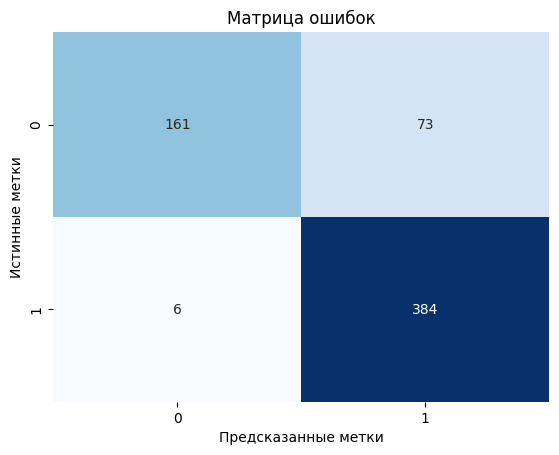

              precision    recall  f1-score   support

      NORMAL       0.96      0.69      0.80       234
   PNEUMONIA       0.84      0.98      0.91       390

    accuracy                           0.87       624
   macro avg       0.90      0.84      0.85       624
weighted avg       0.89      0.87      0.87       624



In [17]:
# сделаем матрицу ошибок
y_pred_proba = model.predict(df_test_processed)
y_pred = (y_pred_proba > 0.5).astype('int32')
y_true = np.concatenate([y for x, y in df_test_processed], axis=0)


cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок')
plt.show()

print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

In [ ]:
# получим изображения для вывода
images = []
for x, _ in df_test_processed.unbatch():
    images.append(x.numpy())

images = np.array(images)

fp_indices = np.where((y_pred == 1) & (y_true == 0))[0]
fn_indices = np.where((y_pred == 0) & (y_true == 1))[0]

In [24]:
# функция вывода изображения
def show_errors(indices, title, num=6):
    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(indices[:num]):
        plt.subplot(2, 3, i+1)
        plt.imshow(images[idx].squeeze(), cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

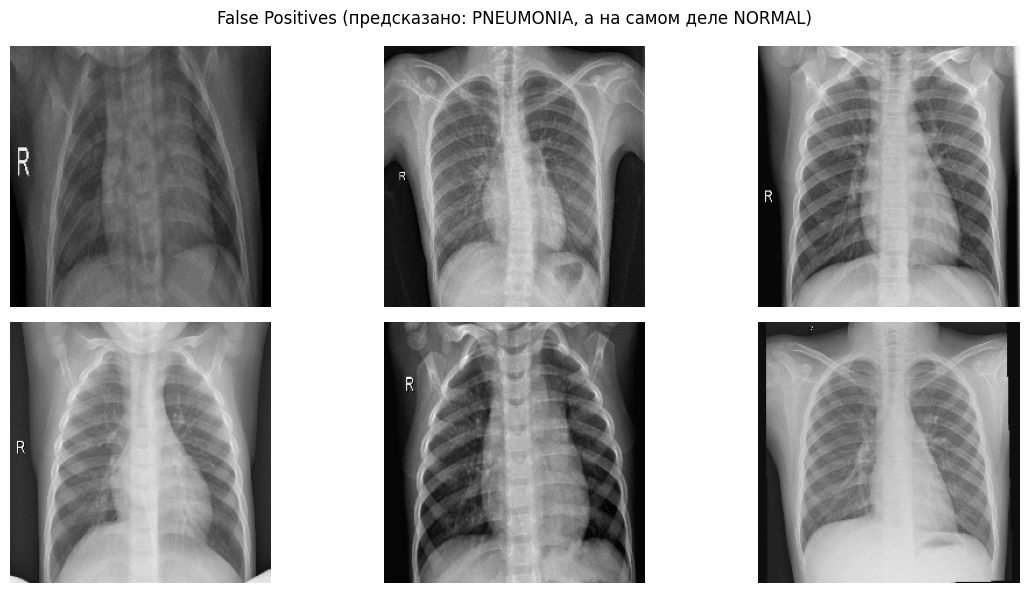

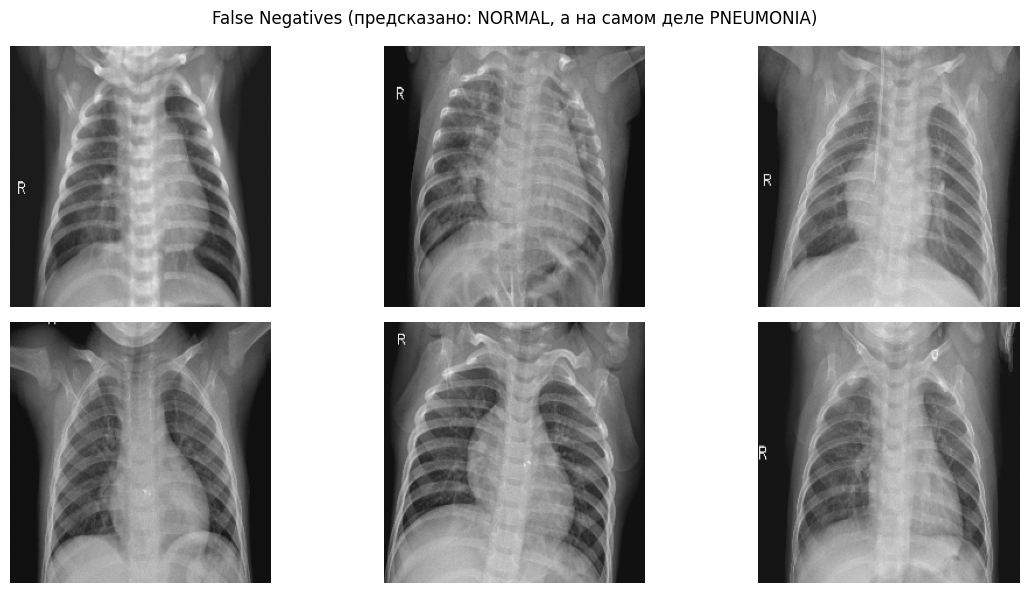

In [ ]:
show_errors(fp_indices, "False Positives (предсказано: PNEUMONIA, а на самом деле NORMAL)")
show_errors(fn_indices, "False Negatives (предсказано: NORMAL, а на самом деле PNEUMONIA)")